In [322]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split

In [323]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import f1_score
from sklearn.feature_selection import SelectFromModel
import seaborn as sns
import scikitplot as skplt
from scipy.stats import chisquare
from scipy.stats import chi2_contingency
from catboost import CatBoostClassifier

In [324]:
df=pd.read_csv('Train_val.csv')
y=pd.read_csv('Train_labels.csv')

In [325]:
y = y.set_index(y.id)
y = y.drop('id', axis=1)

df = df.set_index(df.id)
df = df.drop('id', axis=1)

In [326]:
df.permit = df.permit.replace({'True': 1, 'False': 0, 'NaN': 0})
df.permit = df.permit.fillna(1 if df.permit.mean() > 0.5 else 0)
df.permit = df.permit.astype('int64')

df.public_meeting = df.public_meeting.replace({'True': 1, 'False': 0, 'NaN': 0})
df.public_meeting = df.public_meeting.fillna(1 if df.public_meeting.mean() > 0.5 else 0)
df.public_meeting = df.public_meeting.astype('int64')

In [327]:
def nan_remove(data):
  for col in data.columns:
    if (data[col].dtype == 'int64') or (data[col].dtype == 'float64'):
      data[col].fillna(data[col].mean(), inplace=True)
    else:
      data[col].fillna('unknown', inplace=True)

In [328]:
nan_remove(df)

In [329]:
df['y'] = y
df.date_recorded = pd.to_datetime(df.date_recorded)
df['year_recorder'] = df.date_recorded.dt.year
df['month_recorder'] = df.date_recorded.dt.month
df['day_recorder'] = df.date_recorded.dt.month
df = df.drop("date_recorded", axis=1)

<Axes: >

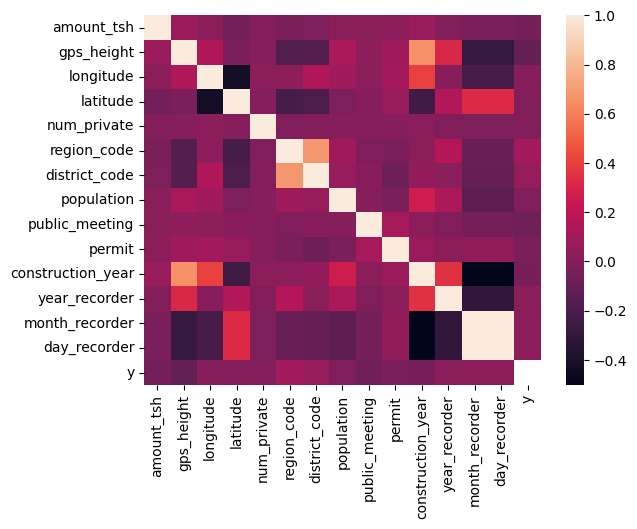

In [330]:
from scipy.stats import chi2_contingency, pointbiserialr

df_check2 = df

# Separate numerical and categorical features
num_features = df_check2.select_dtypes(include=[np.number]).columns.tolist()
# cat_features = df_check2.select_dtypes(exclude=[np.number]).columns[:5].tolist()
cat_features = ['y']

# Calculate correlations
corr_matrix = df_check2[num_features].corr()

# Calculate Cramér's V for categorical features
for cat_i in cat_features:
    for cat_j in cat_features:
        if cat_i != cat_j:
            chi2, _, _, _ = chi2_contingency(pd.crosstab(df_check2[cat_i], df_check2[cat_j]))
            cramers_v = np.sqrt(chi2 / (df_check2.shape[0]))
            corr_matrix.loc[cat_i, cat_j] = cramers_v

# Calculate point-biserial correlation for numerical-categorical pairs
for num in num_features:
    for cat in cat_features:
        # Convert category to codes
        df_check2[cat] = df_check2[cat].astype('category').cat.codes
        pbs_corr, _ = pointbiserialr(df_check2[num], df_check2[cat])
        corr_matrix.loc[num, cat] = pbs_corr
        corr_matrix.loc[cat, num] = pbs_corr

# Heatmap visualization
sns.heatmap(corr_matrix)

In [ ]:
features = df.select_dtypes('object').columns.to_list()
cramers_v_matrix = np.zeros((len(features), len(features)))

def cramers_v(contingency_table, chi2):
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    return np.sqrt(phi2 / min(k - 1, r - 1))


for i, feature_i in enumerate(features):
    for j, feature_j in enumerate(features):
        if i != j:
            chi2, _, _, _ = chi2_contingency(
                pd.crosstab(df[feature_i], df[feature_j]))
            cramers_v_matrix[i, j] = cramers_v(
                pd.crosstab(df[feature_i], df[feature_j]), chi2)
        else:
            cramers_v_matrix[i, j] = 1  # diagonal values are 1

<Axes: >

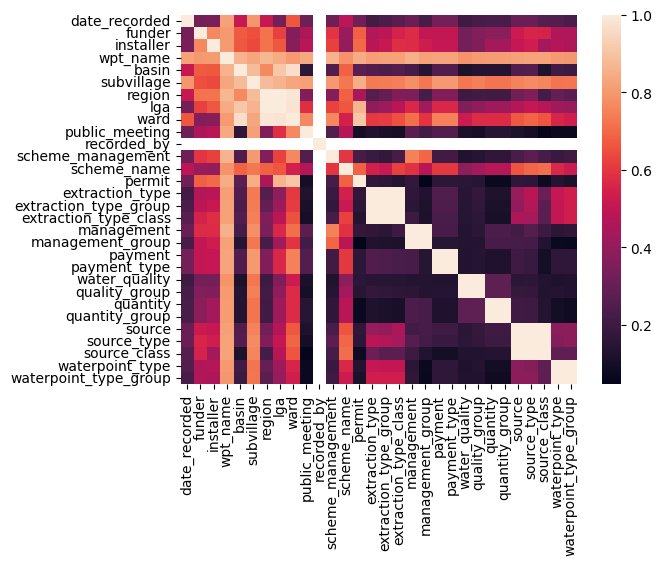

In [100]:
sns.heatmap(cramers_v_matrix,
            xticklabels=features, yticklabels=features)

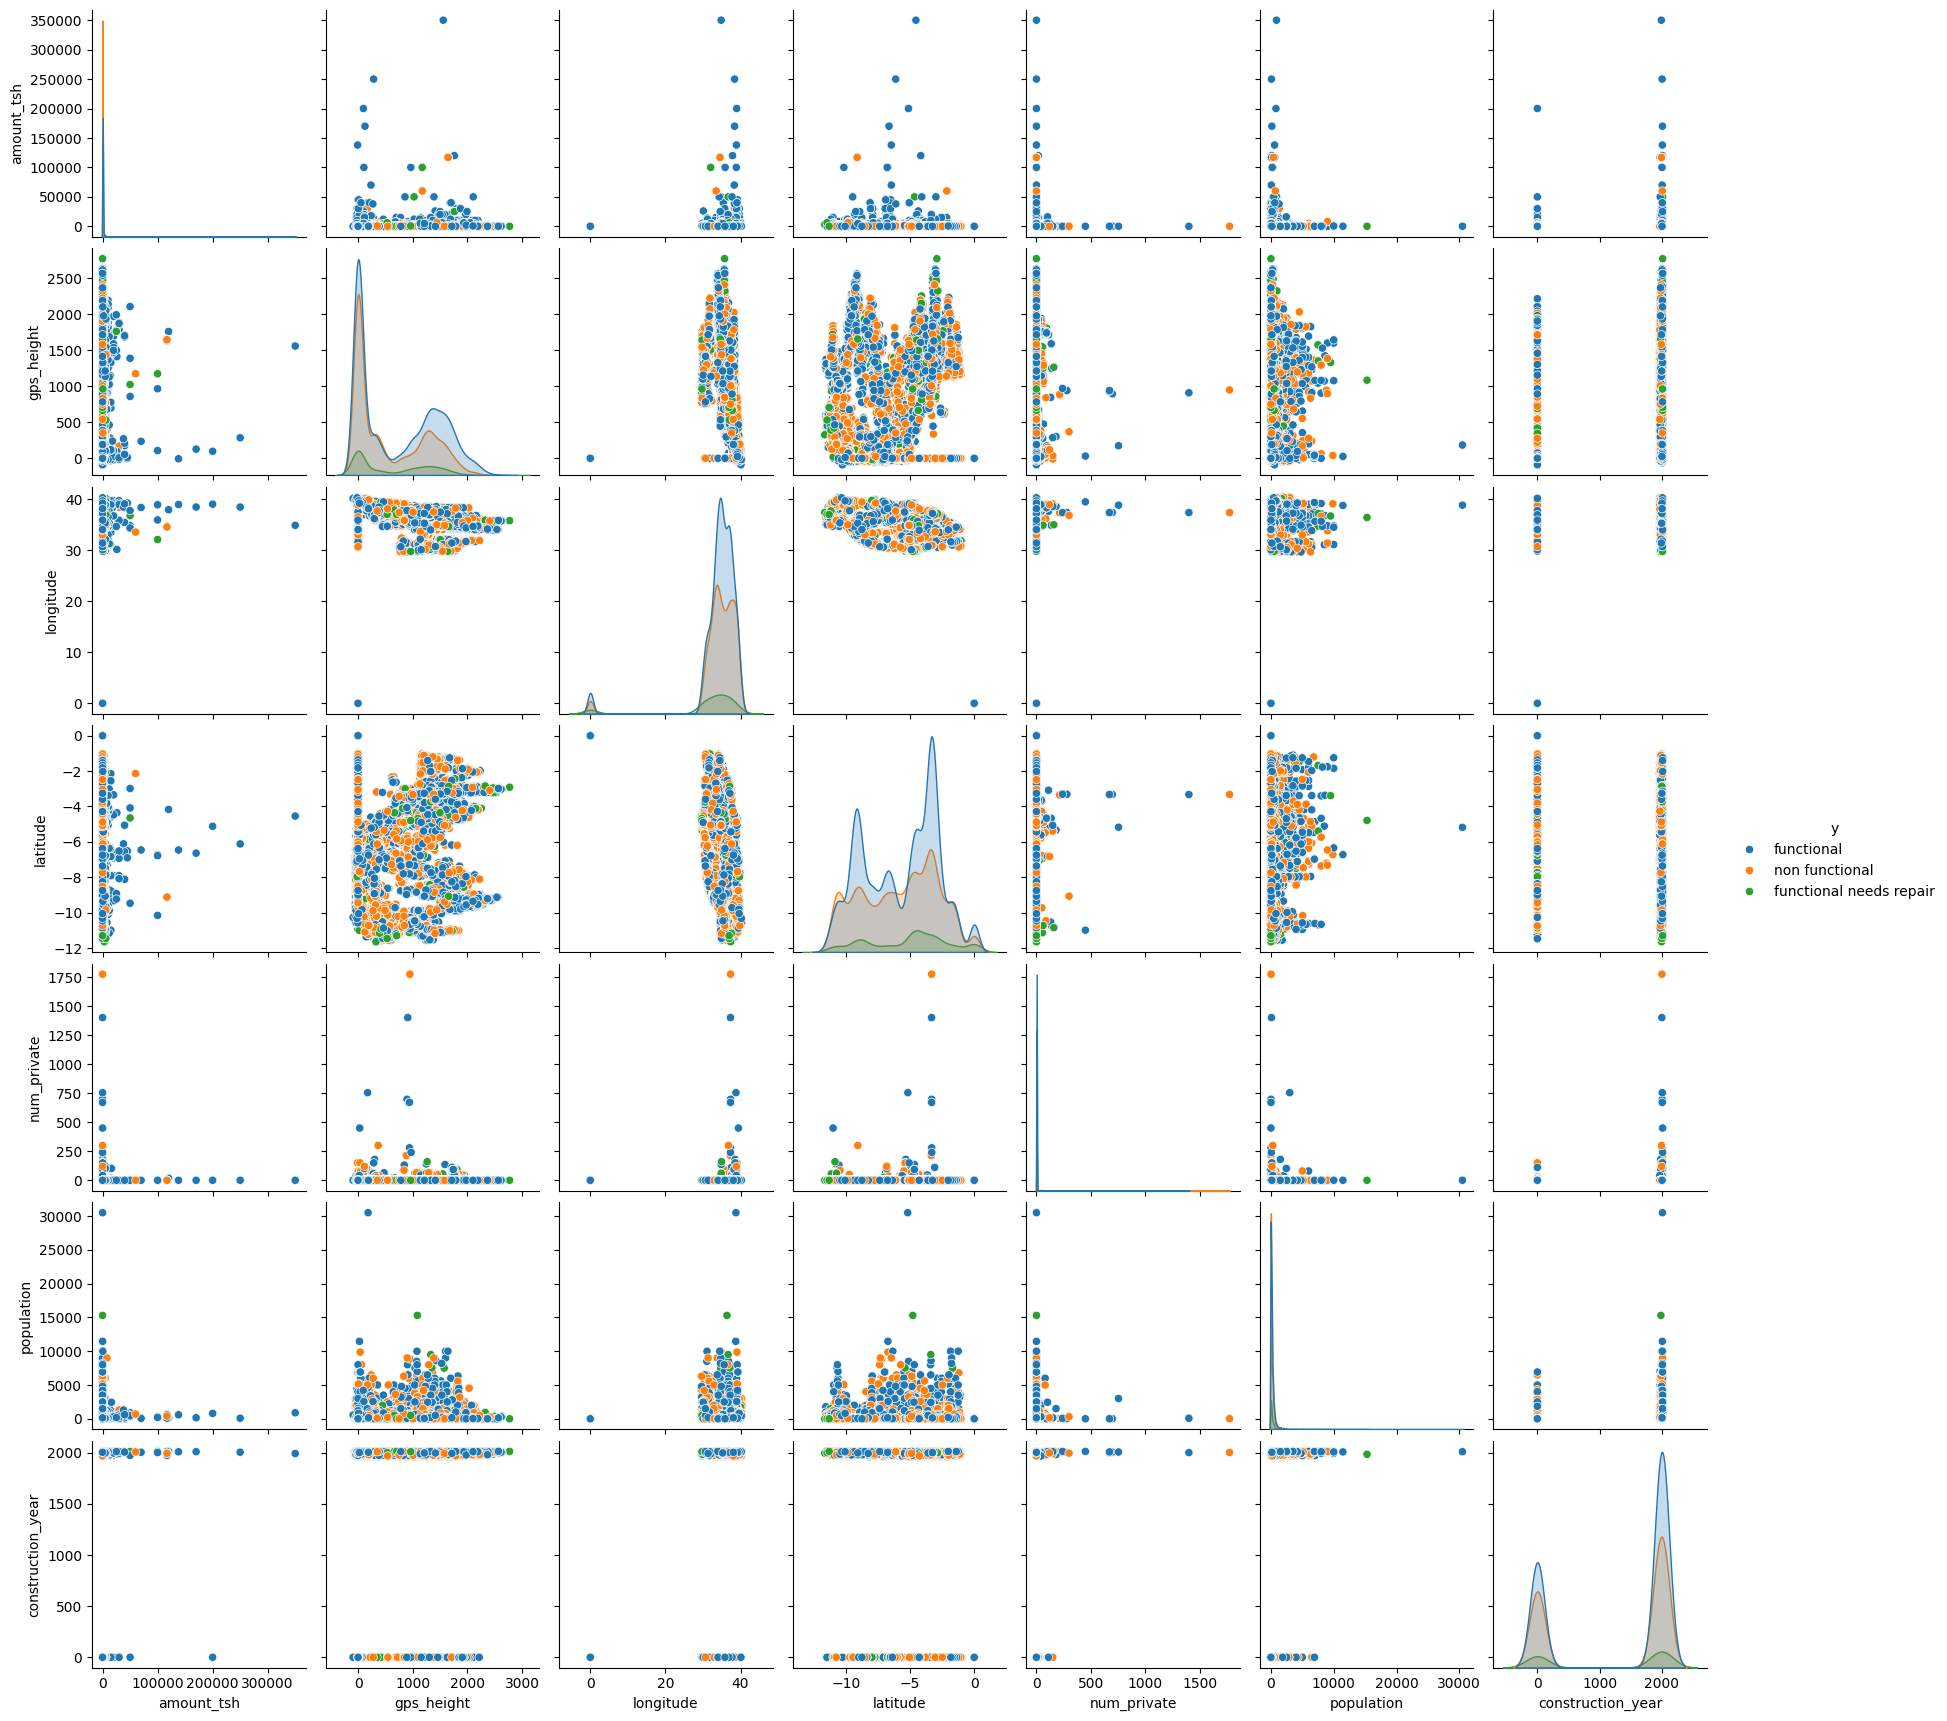

In [120]:
sns.pairplot(df, hue='y', vars=['amount_tsh',
                                 'gps_height',
                                 'longitude',
                                 'latitude',
                                 'num_private',
                                 'population',
                                 'construction_year'])

In [331]:
y = y.replace({'functional':1, 'non functional':0, 'functional needs repair':2})

In [332]:
numericColumns = df.select_dtypes(['int64','int32','float64']).columns

In [333]:
df = df.drop('y', axis=1)

In [334]:
df['region_code'] = df.region_code.astype('object')
df['district_code'] = df.district_code.astype('object')
df = df.drop(['quantity_group', 'basin', 'ward', 'lga', 'recorded_by'], axis=1)

In [335]:
# amount_tsh”, “num_private”, “population”, “construction_year”, “gps_height”
df.amount_tsh = df.amount_tsh.replace(0, df[df.amount_tsh != 0].num_private.mean()).bfill()
df.num_private = df.num_private.replace(0, df[df.num_private != 0].num_private.mean()).bfill()
df.population = df.population.replace(0, df[df.population != 0].population.mean()).bfill()
df.construction_year = df.construction_year.replace(
    0, df[df.construction_year != 0].construction_year.min()).bfill()
df.gps_height = df.gps_height.replace(0, df[df.gps_height != 0].gps_height.mean()).bfill()

Random forest with features preparation

In [336]:
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((47520, 36), (11880, 36))

In [339]:
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        # ("num", numeric_transformer, df.select_dtypes(
        #     ['int64', 'int32', 'float64']).columns),
        ("cat", categorical_transformer, df.select_dtypes('object').columns),
    ]
)

clf = Pipeline(
    steps=[
            ("preprocessor", preprocessor),
           ("classifier", RandomForestClassifier(n_jobs=8))
           ]
)

params = {
          'classifier__n_estimators': [10, 20, 50, 100, 200],
        #   'classifier__criterion': ['gini', 'entropy', 'log_loss'],
        #   'classifier__max_depth': range(1, 20, 5)
          }

rfSearch = GridSearchCV(clf, params, n_jobs=8)

In [242]:
clf.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['funder', 'installer', 'wpt_name', 'subvillage', 'region',
       'region_code', 'district_code', 'scheme_management', 'scheme_name',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object'))])),
                ('classifier', RandomForestClassifier())])

In [243]:
clf.score(X_test, y_test)

0.8003367003367003

In [ ]:
rfSearch.fit(X_train, y_train.values.ravel())

F1_score 0.8010942760942761


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

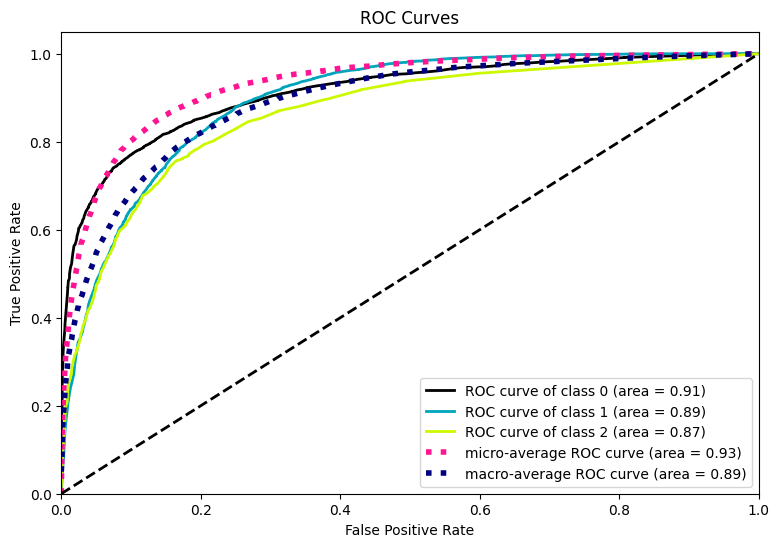

In [256]:
print('F1_score', f1_score(y_test, rfSearch.best_estimator_.predict(X_test), average='micro'))
skplt.metrics.plot_roc(y_test, rfSearch.best_estimator_.predict_proba(X_test), figsize=(9, 6))

Random forest with top-best features

In [ ]:
clf_2 = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("feature_selection", SelectFromModel(
            rfSearch.best_estimator_.named_steps['classifier'], prefit=True)),
        ("classifier", RandomForestClassifier(n_jobs=8))
    ]
)

In [258]:
clf_2.fit(X_train, y_train.values.ravel())

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['funder', 'installer', 'wpt_name', 'subvillage', 'region',
       'region_code', 'district_code', 'scheme_management', 'scheme_name',
       'extraction_type', 'extraction_type_group', 'extraction_type_class',
       'management', 'management_group', 'payment', 'payment_type',
       'water_quality', 'quality_group', 'quantity', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object'))])),
                ('feature_selection',
                 SelectFromModel(estimator=RandomForestClassifier(n_estimators=200),
                                 prefit=True)),
                ('classifier', RandomForestClassifier(n_jobs=8))])

F1_score 0.7961279461279461


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

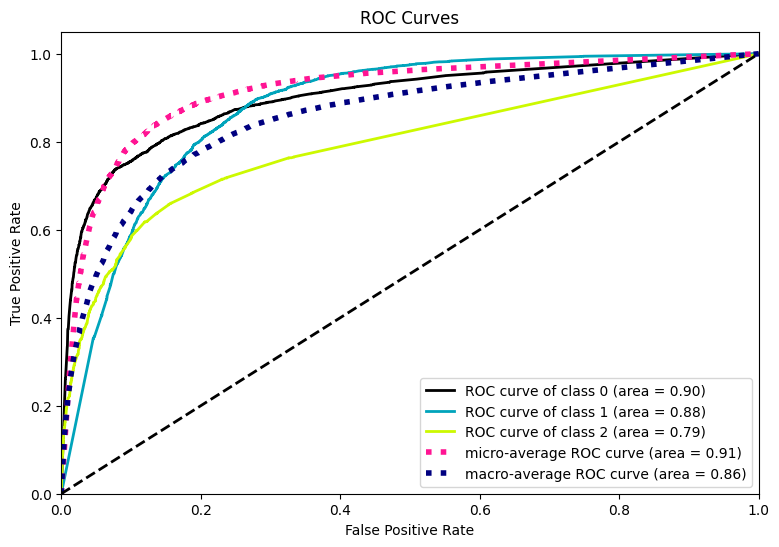

In [259]:
print('F1_score', f1_score(y_test, clf_2.predict(X_test), average='micro'))
skplt.metrics.plot_roc(y_test, clf_2.predict_proba(X_test), figsize=(9, 6))

CatBoost with prepared data

In [260]:
cat_features = [df.columns.get_loc(col) for col in df.select_dtypes(
    include=['object', 'bool', 'O']).columns]

In [ ]:
model_cat = CatBoostClassifier(cat_features=cat_features)
model_cat.fit(X_train, y_train)

F1_score 0.8060606060606059


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

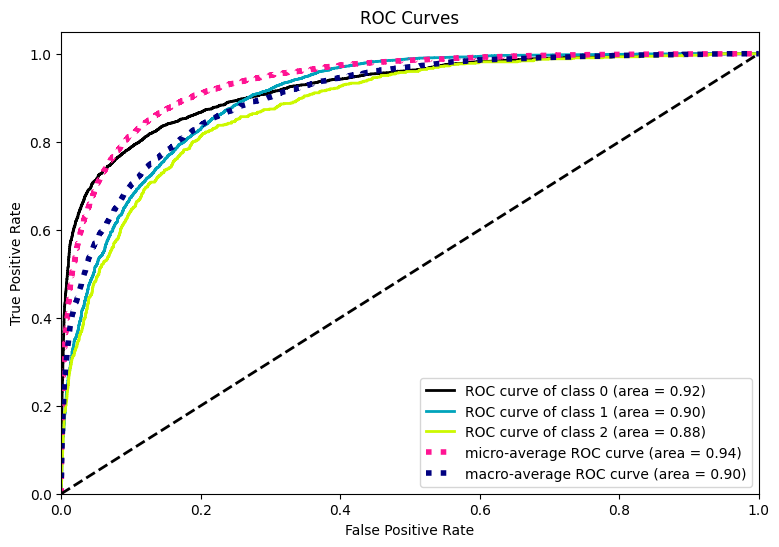

In [262]:
print('F1_score', f1_score(y_test, model_cat.predict(X_test), average='micro'))
skplt.metrics.plot_roc(y_test, model_cat.predict_proba(X_test), figsize=(9, 6))

CatBoost with features preparation, “day_recorder”, “month_recorder”, “year_recorder” columns are presented like categorical features

In [263]:
cat_features.append(list(df.columns).index('day_recorder'))
cat_features.append(list(df.columns).index('month_recorder'))
cat_features.append(list(df.columns).index('year_recorder'))

In [ ]:
model_cat = CatBoostClassifier(cat_features=cat_features)
model_cat.fit(X_train, y_train)

F1_score 0.8068181818181818


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

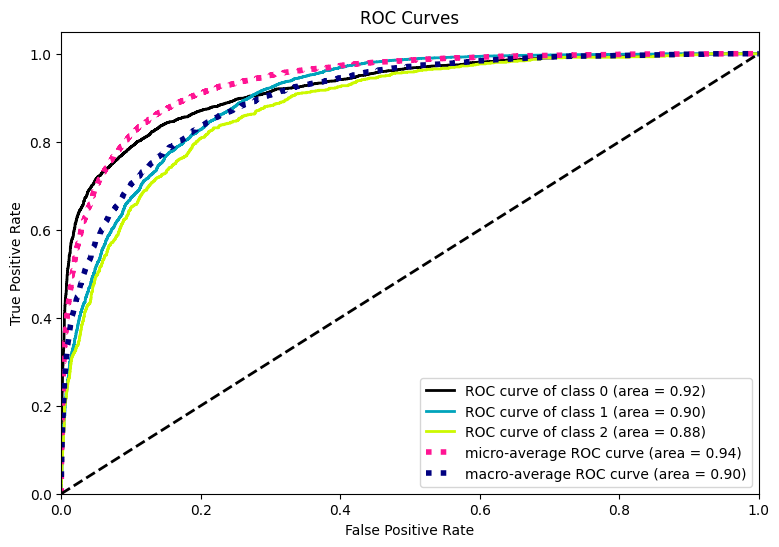

In [265]:
print('F1_score', f1_score(y_test, model_cat.predict(X_test), average='micro'))
skplt.metrics.plot_roc(y_test, model_cat.predict_proba(X_test), figsize=(9, 6))

Clear CatBoost

In [351]:
df=pd.read_csv('Train_val.csv')
y=pd.read_csv('Train_labels.csv')
y = y.set_index(y.id)
y = y.drop('id', axis=1)

df = df.set_index(df.id)
df = df.drop('id', axis=1)

df.permit = df.permit.replace({'True': 1, 'False': 0, 'NaN': 0})
df.permit = df.permit.fillna(1 if df.permit.mean() > 0.5 else 0)
df.permit = df.permit.astype('int64')

df.public_meeting = df.public_meeting.replace(
    {'True': 1, 'False': 0, 'NaN': 0})
df.public_meeting = df.public_meeting.fillna(
    1 if df.public_meeting.mean() > 0.5 else 0)
df.public_meeting = df.public_meeting.astype('int64')

nan_remove(df)
nan_remove(y)

y = y.replace({'functional': 1, 'non functional': 0,
              'functional needs repair': 2})

df.amount_tsh = df.amount_tsh.replace(
    0, df[df.amount_tsh != 0].num_private.min()).bfill()
# df.num_private = df.num_private.replace(
#     0, df[df.num_private != 0].num_private.mean()).bfill()
df.population = df.population.replace(
    0, df[df.population != 0].population.mean()).bfill()
df.construction_year = df.construction_year.replace(
    0, df[df.construction_year != 0].construction_year.min()).bfill()
# df.gps_height = df.gps_height.replace(
#     0, df[df.gps_height != 0].gps_height.mean()).bfill()

cat_features = [df.columns.get_loc(col) for col in df.select_dtypes(
    include=['object', 'bool', 'O']).columns]

In [352]:
X_train, X_test, y_train, y_test = train_test_split(
    df, y, test_size=0.2, random_state=42)

In [ ]:
model_cat_ = CatBoostClassifier(cat_features=cat_features)
model_cat_.fit(X_train, y_train, plot=True)

F1_score 0.810942760942761


<Axes: title={'center': 'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

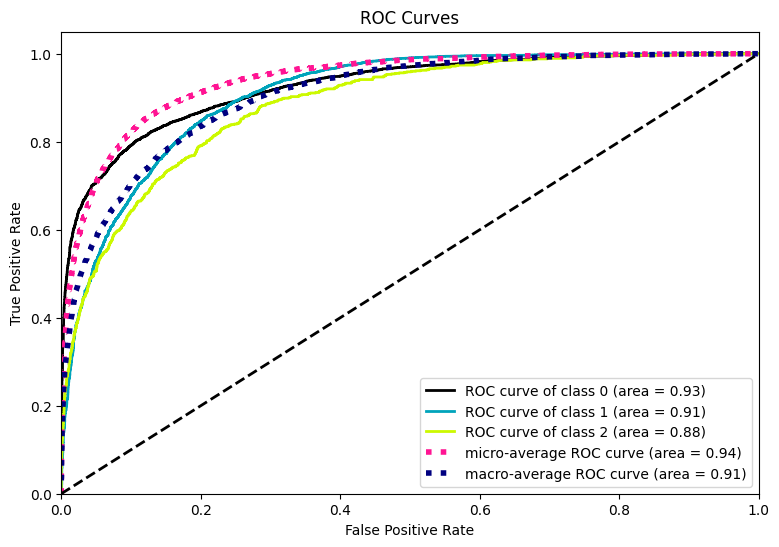

In [350]:
print('F1_score', f1_score(y_test, model_cat.predict(X_test), average='micro'))
skplt.metrics.plot_roc(y_test, model_cat.predict_proba(X_test), figsize=(9, 6))

For send

In [ ]:
model_cat_ = CatBoostClassifier(cat_features=cat_features)
model_cat_.fit(df, y)

In [315]:
test_y = pd.read_csv('SubmissionFormat.csv')
test_val = pd.read_csv('Test_val.csv')

In [316]:
test_val = test_val.set_index(test_val.id)
test_val = test_val.drop('id', axis=1)

test_val.permit = test_val.permit.replace({'True': 1, 'False': 0, 'NaN': 0})
test_val.permit = test_val.permit.fillna(1 if test_val.permit.mean() > 0.5 else 0)
test_val.permit = test_val.permit.astype('int64')

test_val.public_meeting = test_val.public_meeting.replace(
    {'True': 1, 'False': 0, 'NaN': 0})
test_val.public_meeting = test_val.public_meeting.fillna(
    1 if test_val.public_meeting.mean() > 0.5 else 0)
test_val.public_meeting = test_val.public_meeting.astype('int64')

nan_remove(test_val)
nan_remove(y)

y = y.replace({'functional': 1, 'non functional': 0,
              'functional needs repair': 2})

test_val.amount_tsh = test_val.amount_tsh.replace(
    0, test_val[test_val.amount_tsh != 0].num_private.min()).bfill()
# test_val.num_private = test_val.num_private.replace(
#     0, test_val[test_val.num_private != 0].num_private.mean()).bfill()
test_val.population = test_val.population.replace(
    0, test_val[test_val.population != 0].population.min()).bfill()
test_val.construction_year = test_val.construction_year.replace(
    0, test_val[test_val.construction_year != 0].construction_year.min()).bfill()
# test_val.gps_height = test_val.gps_height.replace(
#     0, test_val[test_val.gps_height != 0].gps_height.mean()).bfill()

cat_features = [test_val.columns.get_loc(col) for col in test_val.select_dtypes(
    include=['object', 'bool', 'O']).columns]


In [318]:
pred_y = model_cat.predict(test_val)

In [319]:
test_y = test_y.drop('status_group', axis=1)
test_y['status_group'] = pred_y

In [320]:
test_y = test_y.replace({1.0: 'functional', 0.0: 'non functional',
              2.0: 'functional needs repair'})
test_y = test_y.set_index(test_y.id)
test_y = test_y.drop('id', axis=1)

In [321]:
test_y.to_csv('res.csv')